In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot
%matplotlib inline

In [4]:
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 1.7 MB/s eta 0:00:00


In [5]:
import patoolib

In [6]:
patoolib.extract_archive('/content/drive/MyDrive/archive.zip')

patool: Extracting /content/drive/MyDrive/archive.zip ...
patool: running /usr/bin/7z x -o./Unpack_8430luq5 -- /content/drive/MyDrive/archive.zip
patool: ... /content/drive/MyDrive/archive.zip extracted to `Data'.


'Data'

In [7]:
import os
Root = '/content/Data'
os.chdir(Root)

In [20]:
audio_dataset_path = '/content/Data/genres_original'
metadata = pd.read_csv('/content/Data/features_30_sec.csv')
metadata.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [21]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type = 'kaiser_fast') #file name --> blues...
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfcc_scaled_features = np.mean(mfccs_features.T, axis=0)

    return mfcc_scaled_features

In [22]:
metadata.drop(labels=552, axis=0, inplace=True)

In [23]:
from tqdm import tqdm
### Now we iterate through every audio file and extract features
### using Mel-Frequency Cepstral Coefficients

extracted_features=[]
for index_num, row in tqdm(metadata.iterrows()):
    try:
        final_class_labels=row['label']
        file_name = os.path.join(os.path.abspath(audio_dataset_path), final_class_labels+'/',str(row["filename"]))
        data=features_extractor(file_name)
        extracted_features.append([data,final_class_labels])
    except Exception as e:
        print(f'Error: {e}')
        continue

552it [00:56, 11.16it/s]<ipython-input-21-2a442176a60f>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_name, res_type = 'kaiser_fast') #file name --> blues...
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
556it [00:56,  9.78it/s]

Error: 


999it [01:42,  9.71it/s]


In [24]:
###converting extracted_features to pandas dataframe
extracted_features_df = pd.DataFrame(extracted_features, columns=['features','class'])
extracted_features_df.head()

,features,class
0,"[-113.59882, 121.57067, -19.162262, 42.36394, ...",blues
1,"[-207.52383, 123.98514, 8.94702, 35.86715, 2.9...",blues
2,"[-90.757164, 140.44087, -29.084547, 31.686693,...",blues
3,"[-199.57513, 150.0861, 5.663404, 26.855282, 1....",blues
4,"[-160.35417, 126.20948, -35.581394, 22.139256,...",blues


In [25]:
extracted_features_df['class'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
metal        100
pop          100
reggae       100
rock         100
jazz          98
Name: class, dtype: int64

In [26]:
X=np.array(extracted_features_df['features'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [27]:
X.shape

(998, 40)

In [29]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [30]:
y.shape

(998, 10)

In [31]:
##TRAIN TEST SPLITTING
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [32]:
X_train

array([[-1.04723763e+02,  8.77537155e+01, -3.32488594e+01, ...,
        -2.38248777e+00, -1.36347139e+00, -7.22123504e-01],
       [-2.59909851e+02,  1.23193169e+02, -6.39508581e+00, ...,
        -6.73697758e+00, -3.90829611e+00,  3.18117642e+00],
       [-1.15755066e+02,  6.70791245e+01,  1.88346851e+00, ...,
        -3.43661404e+00, -1.73870683e+00, -4.68738452e-02],
       ...,
       [-1.25020428e+01,  9.13173676e+01, -2.30759563e+01, ...,
        -4.04763985e+00, -1.77685583e+00, -1.75431299e+00],
       [-2.37930965e+01,  8.29835587e+01,  2.32049274e+00, ...,
         1.40550280e+00,  4.16220456e-01, -3.45980562e-02],
       [-9.63197021e+01,  9.09497147e+01, -3.22195396e+01, ...,
        -2.41483903e+00, -1.62698299e-01, -1.84749973e+00]], dtype=float32)

In [33]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(798, 40)
(200, 40)
(798, 10)
(200, 10)


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [35]:
num_labels=y.shape[1]

In [36]:
y.shape[1]

10

In [37]:
model=Sequential()
model.add(Dense(1024, input_shape=(40,), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, input_shape=(40,), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, input_shape=(40,), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, input_shape=(40,), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, input_shape=(40,), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, input_shape=(40,), activation='relu'))
model.add(Dropout(0.3))

###final layer
model.add(Dense(num_labels, activation='softmax'))

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              41984     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

In [39]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [40]:
import time
t=time.localtime()
current_time=time.strftime('%H:%M:%S',t)

In [72]:
###Training my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 10
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath = f'saved_models/audio_classification_{current_time}.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()
history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose = 1)
duration = datetime.now() - start
print('Training completed in time: ', duration)

Epoch 1/10
23/25 [==========================>...] - ETA: 0s - loss: 0.0799 - accuracy: 0.9810
Epoch 1: val_loss improved from inf to 3.72248, saving model to saved_models/audio_classification_19:43:39.hdf5
25/25 [==============================] - 1s 26ms/step - loss: 0.0768 - accuracy: 0.9825 - val_loss: 3.7225 - val_accuracy: 0.6050
Epoch 2/10
23/25 [==========================>...] - ETA: 0s - loss: 0.0859 - accuracy: 0.9810
Epoch 2: val_loss did not improve from 3.72248
25/25 [==============================] - 1s 25ms/step - loss: 0.0943 - accuracy: 0.9812 - val_loss: 4.3055 - val_accuracy: 0.6000
Epoch 3/10
24/25 [===========================>..] - ETA: 0s - loss: 0.1003 - accuracy: 0.9766
Epoch 3: val_loss did not improve from 3.72248
25/25 [==============================] - 1s 24ms/step - loss: 0.0995 - accuracy: 0.9762 - val_loss: 4.0125 - val_accuracy: 0.6200
Epoch 4/10
24/25 [===========================>..] - ETA: 0s - loss: 0.0874 - accuracy: 0.9818
Epoch 4: val_loss did not im

In [73]:
model.evaluate(X_test, y_test, verbose=0)

[3.598954200744629, 0.6299999952316284]

<Axes: >

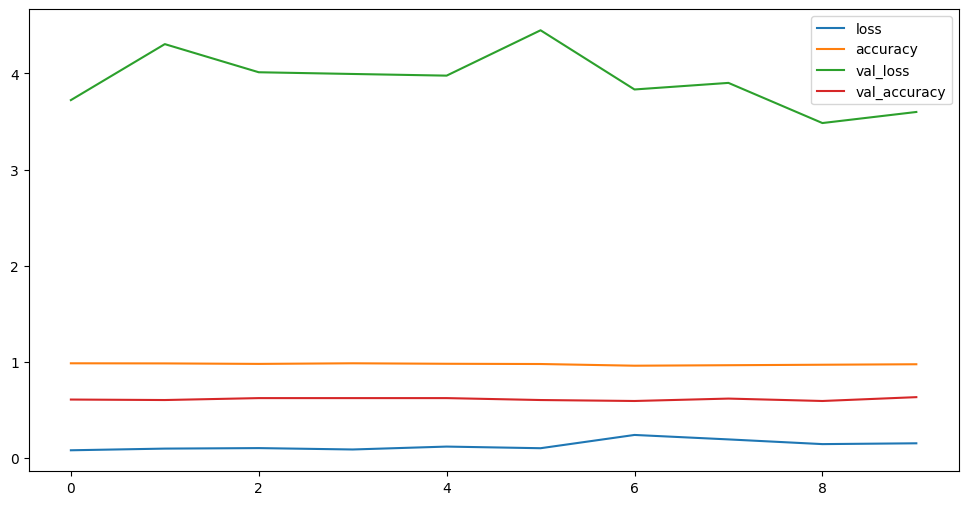

In [75]:
pd.DataFrame(history.history).plot(figsize=(12,6))

In [ ]:
model.predict_classes(X_test)

In [80]:
filename = '/content/Data/genres_original/jazz/jazz.00002.wav'
audio, sample_rate = librosa.load(filename, res_type = 'kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
print(mfccs_scaled_features)
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features.shape)
class_probabilities = model.predict(mfccs_scaled_features)
# Get the index of the class with the highest probability
predicted_index = np.argmax(class_probabilities, axis=1)
# Convert the index to the actual class label using your labelencoder
predicted_label = labelencoder.inverse_transform(predicted_index)
print(predicted_label)

[-2.56981812e+02  1.75339539e+02 -4.48154488e+01  2.56386490e+01
 -4.25749016e+00 -2.26352826e-01 -1.13197775e+01 -9.18636513e+00
 -4.10228777e+00 -8.30701256e+00 -2.25540695e+01 -7.60940981e+00
 -7.65619707e+00 -1.17447672e+01 -8.17417240e+00 -7.50161982e+00
 -1.22968435e+01 -6.76809645e+00 -3.50023198e+00 -8.64859104e+00
 -8.52417755e+00 -4.61773968e+00 -5.83067751e+00 -7.82939386e+00
 -1.08265471e+00 -2.91915154e+00 -2.05345583e+00  2.68332273e-01
 -3.42445564e+00 -6.23867989e+00  7.63419211e-01 -1.40147641e-01
 -5.64932966e+00 -6.80001926e+00 -3.56003070e+00 -4.60261631e+00
 -4.78497446e-01  3.18785572e+00 -5.01118541e-01 -9.88649070e-01]
(1, 40)
1/1 [==============================] - 0s 33ms/step
['jazz']
